In [42]:
import pandas as pd
import numpy as np

url = "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data"

# Load the SAheart dataset
df = pd.read_csv(url, index_col='row.names')

# Convert binary text data to numbered categories
df['famhist'] = pd.Categorical(df['famhist']).codes

# Extract the name of the attributes (columns)
attributeNames = list(map(lambda x: x.capitalize(), df.columns.tolist()))

# Convert the dataframe to numpy
y = df['chd'].to_numpy() # classification problem of CHD or no CHD
X = df.drop(columns=['chd']).to_numpy() # rest of the attributes, remove 'CHD' column

# Compute size of X
N, M = X.shape # N = observations, M = attributes (except 'chd')
N_numbers = np.arange(1, N+1)

# Normalize the datapoints to have a mean of 0 
mu = np.mean(X, 0)
sigma = np.std(X, 0)

X = (X - mu) / sigma


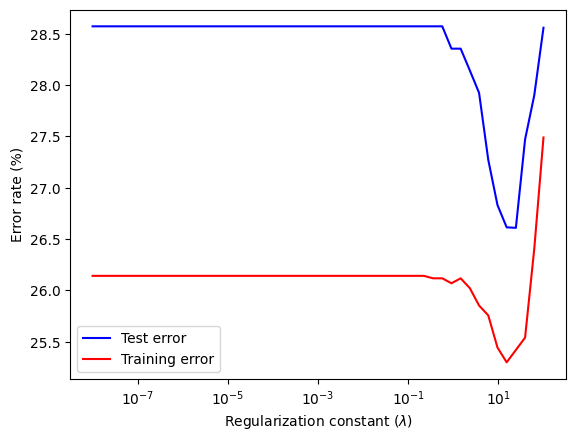

In [43]:
# Find the best regularization value for logistic regression.ipynb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
import matplotlib.pyplot as plt

lambda_reg =  np.logspace(-8, 2, 50)

# Using K-fold 10 cross validation
K_fold = 10
CV = model_selection.KFold(K_fold)

train_error = np.zeros((K_fold, len(lambda_reg)))
test_error = np.zeros((K_fold, len(lambda_reg)))
coefficient_norm = np.zeros((K_fold, len(lambda_reg)))

i = 0  # Reset i to 0 at the start of the outer loop
for train_index, test_index in CV.split(X, y):
    #print("Crossvalidation fold: {0}/{1}".format(i + 1, 10))

    # extract training and test set for current CV fold
    X_train = X[train_index, :]
    y_train = y[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]

    for l in range(len(lambda_reg)):
        #print("Regularization constant: {0}".format(lambda_reg[l]))

        # train model
        model_logreg = LogisticRegression(penalty="l2", C=1/lambda_reg[l], max_iter=500)
        model_logreg.fit(X_train, y_train)

        # predict test and training data
        y_est_test = model_logreg.predict(X_test)
        y_est_train = model_logreg.predict(X_train)

        error_rate_test = 100 * np.sum(y_est_test != y_test)/len(y_test)
        error_rate_train = 100 * np.sum(y_est_train != y_train)/len(y_train)

        w_est = model_logreg.coef_[0]
        coeff_norm = np.sqrt(np.sum(w_est**2))

        test_error[i,l] = error_rate_test
        train_error[i,l] = error_rate_train
        coefficient_norm[i,l] = coeff_norm

    i += 1

# Plot the classification error rate
plt.figure()
plt.semilogx(lambda_reg, np.mean(test_error, axis=0), color='b', label='Test error')
plt.semilogx(lambda_reg, np.mean(train_error, axis=0), color='r', label='Training error')
plt.legend()
plt.xlabel(f'Regularization constant ($\lambda$)')
plt.ylabel("Error rate (%)")
plt.show()


Crossvalidation fold: 1/10
Crossvalidation fold: 2/10
Crossvalidation fold: 3/10
Crossvalidation fold: 4/10
Crossvalidation fold: 5/10
Crossvalidation fold: 6/10
Crossvalidation fold: 7/10
Crossvalidation fold: 8/10
Crossvalidation fold: 9/10
Crossvalidation fold: 10/10


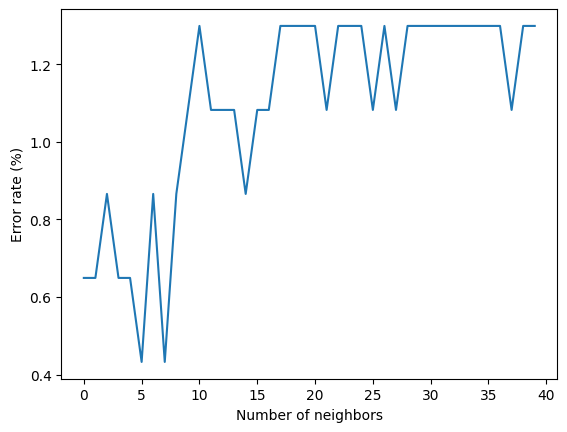

The optimal k-nearest neigbor is k = [1, 15]


In [44]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

# Find the optimal number of neighbors

# Maximum number of neighbors
L = 40

CV = model_selection.KFold(10)
errors = np.zeros((N, L))
i = 0
for train_index, test_index in CV.split(X, y):
    print("Crossvalidation fold: {0}/{1}".format(i + 1, 10))

    # extract training and test set for current CV fold
    X_train = X[train_index, :]
    y_train = y[train_index]
    N1_numbers_train = N_numbers[train_index]
    X_test = X[test_index, :]
    y_test = y[test_index]
    N1_numbers_test = N_numbers[test_index]
    
    # Fit classifier and classify the test points for each neighbors
    for l in range(1, L + 1): 
        knclassifier = KNeighborsClassifier(n_neighbors=l) # choose the model
        knclassifier.fit(X_train, y_train) # fits the model to X_train, y_train
        y_est = knclassifier.predict(X_test) # estimate y from X_test
        errors[i, l - 1] = np.sum(y_est[0] != y_test[0]) # error for each l (column) in the current fold
        # errors is a matrix of l columns and K_folds

    i += 1

# Plot the classification error rate
plt.figure()
plt.plot(100 * sum(errors, 0) / N) # plot mean error of each l for all cross validations
plt.xlabel("Number of neighbors")
plt.ylabel("Error rate (%)")
plt.show()

print('The optimal k-nearest neigbor is k = [1, 15]')


In [46]:
# Two-layer cross validation

# K-fold for cross validation
Kfold = 10
CV = model_selection.KFold(Kfold)
error_OUT = []

k = 0
lambdas = 10
# Outer fold
for train_index_out, test_index_out in CV.split(X,y):
    print("# Outer fold: {0}/{1}".format(k + 1, Kfold))
    
    # Extract the training and test set for the outer-fold
    X_train_out = X[train_index_out, :]
    y_train_out = y[train_index_out]
    X_test_out = X[test_index_out, :]
    y_test_out = y[test_index_out]

    i = 0 # Index for inner fold
    error_IN = [] # Emptry list for inner fold errors
    
    # Inner fold
    for train_index, test_index in CV.split(X_train_out, y_train_out):
        print("Inner fold: {0}/{1}".format(i + 1, Kfold))

        # Extract training and test set for current inner fold
        X_train = X_train_out[train_index, :]
        y_train = y_train_out[train_index]
        X_test = X_train_out[test_index, :]
        y_test = y_train_out[test_index]
        

        # Training and test of the three models
        ## K-nearest neigbors 
        k_KNN = 5
        metric='mahalanobis'
        metric_params={'V': np.cov(X_train, rowvar=False)}
        knclassifier = KNeighborsClassifier(n_neighbors=k_KNN, p = 1, metric = metric, metric_params = metric_params)
        knclassifier.fit(X_train, y_train)

        # test
        y_est_KNN = knclassifier.predict(X_test)
        Missclass_KNN = np.sum(y_est_KNN != y_test)
       
        ## Logistic Regression
        logisticclassifier = LogisticRegression(C = 1/lambdas, max_iter = 500)
        logisticclassifier.fit(X_train, y_train)
        
        # test
        y_est_LOGREG = logisticclassifier.predict(X_test)
        Missclass_LOGREG = np.sum(y_est_LOGREG != y_test)
        
        ## Baseline
        a = 0 # No CHD class
        b = 0 # CHD class
        while True:
            for c in range(len(y_train)):
                if y_train[c] == 0:
                    a += 1
                elif y_train[c] == 1:
                    b += 1
           
            # test
            if a > b: # If the class of no CHD (a) is largest
                y_est_base = np.full(len(y_test), 0) # baseline predicts all y's to not have CHD
                break
            else: # If the class of CHD (b) is largest
                y_est_base = np.full(len(y_test), 1) # baseline predicts all y's to have CHD
                break
        Missclass_base = np.sum(y_est_base != y_test)
        
        # Add the errors to the list
        error_IN.append([(Missclass_KNN/len(y_test)), (Missclass_LOGREG/len(y_test)), (Missclass_base/len(y_test))])
        i += 1
    
    # Find the sum of the errors of each model for the inner fold
    error_in_KNN_sum = 100 * np.sum((len(y_test)/len(y_train_out)) * np.array(error_IN)[:, 0])
    error_in_LOGREG_sum = 100 * np.sum((len(y_test)/len(y_train_out)) * np.array(error_IN)[:, 1])
    error_in_base_sum = 100 * np.sum((len(y_test)/len(y_train_out)) * np.array(error_IN)[:, 2])

    error_OUT.append([error_in_KNN_sum, error_in_LOGREG_sum, error_in_base_sum])

    k += 1



Class_df_columns = pd.MultiIndex.from_tuples([
    ("Outer fold", "i"), 
    ("KNN", "k"),
    ("KNN", "Error_test (%)"),
    ("Logistic regression", "lambda"),
    ("Logistic regression", "Error_test(%)"),
    ("Baseline", "Error_test(%)")])

Outer_fold = np.round(np.arange(1, Kfold + 1),0)
 
Class_df_data = np.array([Outer_fold, 
                          np.full(Kfold, k_KNN), # k-value
                          np.round(np.array(error_OUT)[:,0],2), # Error_test of KNN
                          np.full(Kfold, 0), # Lambda
                          np.round(np.array(error_OUT)[:,1],2), # Error_test of logistic function
                          np.round(np.array(error_OUT)[:,2],2)]).T

Class_df = pd.DataFrame(Class_df_data, columns=Class_df_columns)
print(Class_df)


# Outer fold: 1/10
Inner fold: 1/10
Inner fold: 2/10
Inner fold: 3/10
Inner fold: 4/10
Inner fold: 5/10
Inner fold: 6/10
Inner fold: 7/10
Inner fold: 8/10
Inner fold: 9/10
Inner fold: 10/10
# Outer fold: 2/10
Inner fold: 1/10
Inner fold: 2/10
Inner fold: 3/10
Inner fold: 4/10
Inner fold: 5/10
Inner fold: 6/10
Inner fold: 7/10
Inner fold: 8/10
Inner fold: 9/10
Inner fold: 10/10
# Outer fold: 3/10
Inner fold: 1/10
Inner fold: 2/10
Inner fold: 3/10
Inner fold: 4/10
Inner fold: 5/10
Inner fold: 6/10
Inner fold: 7/10
Inner fold: 8/10
Inner fold: 9/10
Inner fold: 10/10
# Outer fold: 4/10
Inner fold: 1/10
Inner fold: 2/10
Inner fold: 3/10
Inner fold: 4/10
Inner fold: 5/10
Inner fold: 6/10
Inner fold: 7/10
Inner fold: 8/10
Inner fold: 9/10
Inner fold: 10/10
# Outer fold: 5/10
Inner fold: 1/10
Inner fold: 2/10
Inner fold: 3/10
Inner fold: 4/10
Inner fold: 5/10
Inner fold: 6/10
Inner fold: 7/10
Inner fold: 8/10
Inner fold: 9/10
Inner fold: 10/10
# Outer fold: 6/10
Inner fold: 1/10
Inner fold: 2/